# wet bulb globe exposure analysis WBGT99 

Look at nAHD, PR and deltaI for WBGT99 for different age groups: key global results and plots

rosa.pietroiusti@vub.be

Created April 8th 2024




TODO : 

- in another notebook ! Fixed thresholds - also for tasmax 
- in other notebook start on country level analysis 
- make some better analysis of my results, key numbers, check my aggregation code etc. - make this a fxn 

In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy, openpyxl, (statsmodels?)

import numpy as np
import pandas as pd
import os, glob, re 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
import netCDF4

%matplotlib inline

#plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import my variables settings functions from other scripts
from settings import *

# import fxns 
from functions import *
from utils import *
from plotscript import *

# import other packages/modules 

sys.path.append('../population/') # make this a module i can pip install and import ! 
from population_demographics_climate import * # move / rename this when good ! --> change to import demographics4climate as d4c


/apps/brussel/RL8/skylake/software/Python/3.10.4-GCCcore-11.3.0/lib/python3.10/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
/apps/brussel/RL8/skylake/software/statsmodels/0.13.1-foss-2022a/lib/python3.10/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
from dask.distributed import Client 
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 60.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43719,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 60.00 GiB
Comm: tcp://127.0.0.1:35855,Total threads: 1
Dashboard: http://127.0.0.1:40741/status,Memory: 30.00 GiB
Nanny: tcp://127.0.0.1:37231,


In [ ]:
start_message() # change indir to indir obs and datasets to datasets obs in start message

## Open and plot WBGT99 PR, deltaI, nAHD

In [53]:
outdirname=outdirnames['WBGT99']
outdirname

'output_apr24-9115544-wbgt99'

In [5]:
da_WBGT99_pi = open_all_TX_preindustrial(GCMs, metric='WBGT99', outdirname=outdirname)
#da_WBGT99_pi

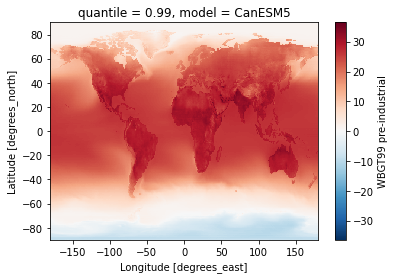

In [6]:
da_WBGT99_pi.isel(model=0).plot()

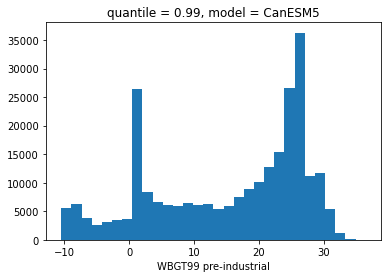

In [7]:
da_WBGT99_pi.isel(model=0).plot.hist(bins=30);

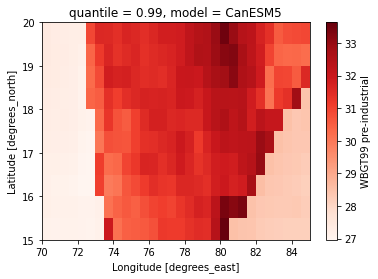

In [8]:
da_WBGT99_pi.isel(model=0).sel(lat=slice(20,15), lon=slice(70,85)).plot(cmap='Reds')

/apps/brussel/RL8/skylake/software/xarray/2022.6.0-foss-2022a/lib/python3.10/site-packages/xarray/coding/times.py:682: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/apps/brussel/RL8/skylake/software/xarray/2022.6.0-foss-2022a/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


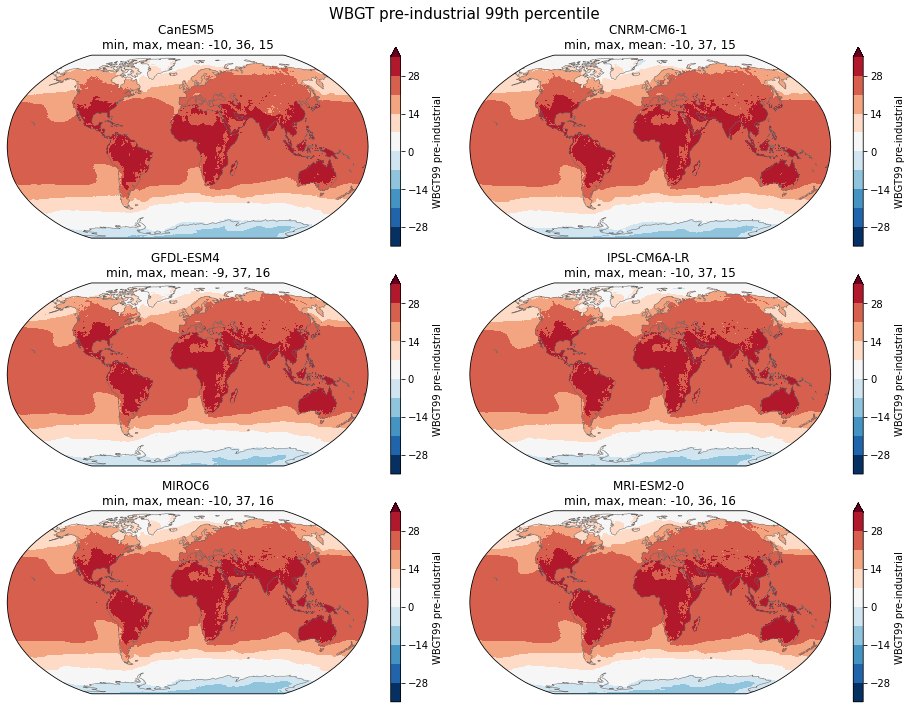

In [9]:
proj = ccrs.Robinson()
landmask = get_mask()
crs = ccrs.PlateCarree()
vmax = 35
levels = np.linspace(-vmax,vmax,num=20)

fig, axes = plt.subplots(3,2,figsize=(13,10), subplot_kw={'projection': proj})
axes = axes.flatten() 

for GCM, ax in zip(GCMs, axes):
    data_plot = (da_WBGT99_pi.sel(model=GCM)) #*landmask
    data_plot.plot(ax=ax, cmap = 'RdBu_r', vmax=vmax, vmin=-vmax, levels=11, transform=crs, extend='max') 
    ax.set_title(f'{GCM} \nmin, max, mean: {data_plot.min():.0f}, {data_plot.max():.0f}, {data_plot.mean():.0f}')
    ax.coastlines(color='dimgray', linewidth=0.5)
    #ax.add_feature(cfeature.BORDERS, facecolor="none", edgecolor='dimgray', linewidth=0.5 )
    
fig.suptitle('WBGT pre-industrial 99th percentile', size=15);
fig.tight_layout()

# is this correct??? check this! 

In [10]:
da_WBGT99_PR=open_all_PR(GCMs, metric='WBGT99', outdirname=outdirname)

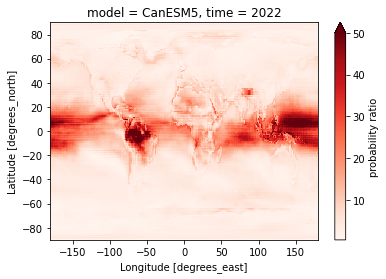

In [11]:
da_WBGT99_PR.isel(model=0).plot(cmap='Reds',vmax=50)

/apps/brussel/RL8/skylake/software/xarray/2022.6.0-foss-2022a/lib/python3.10/site-packages/xarray/coding/times.py:682: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/apps/brussel/RL8/skylake/software/xarray/2022.6.0-foss-2022a/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/apps/brussel/RL8/skylake/software/xarray/2022.6.0-foss-2022a/lib/python3.10/site-packages/xarray/coding/times.py:682: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_d

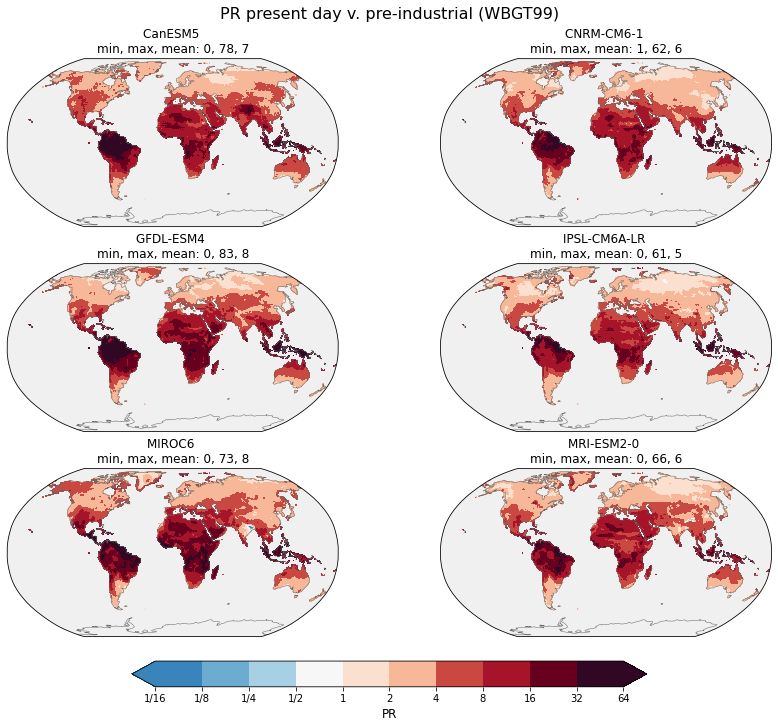

In [12]:
#inputs to functions
bounds, cmap = calc_bounds_cmap_PR_power(7, 'RdBu_r', skew=2)
smooth = 0.3
proj = ccrs.Robinson()

fig, axes = plt.subplots(3,2,figsize=(12,10), subplot_kw={'projection': proj},  layout='constrained')
axes = axes.flatten() 

for GCM, ax in zip(GCMs, axes):
    data_plot = da_WBGT99_PR.sel(model=GCM)
    plot = plot_PR(data_plot, ax, cmap, bounds, title='summary_stats', smooth=0.3, mask=True)

cbar_lab = 'PR' # try to get TeX interpreter 'less likely $\leftarrow$ PR $\rightarrow$ more likely' #'PR' # add more/less likely arrow 
cbar = fig.colorbar(plot, ticks=bounds, extend='both', ax=axes, shrink=0.6, location='bottom', fraction= 0.045, pad= 0.04) #location='bottom' 
labels = ['1/{}'.format(int(1/t)) if t<1 else str(t) for t in bounds]
cbar.ax.set_xticklabels(labels)
cbar.set_label(label=cbar_lab, size=12) 

fig.suptitle('PR present day v. pre-industrial (WBGT99)', size=16);

/apps/brussel/RL8/skylake/software/xarray/2022.6.0-foss-2022a/lib/python3.10/site-packages/xarray/coding/times.py:682: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/apps/brussel/RL8/skylake/software/xarray/2022.6.0-foss-2022a/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/apps/brussel/RL8/skylake/software/xarray/2022.6.0-foss-2022a/lib/python3.10/site-packages/xarray/coding/times.py:682: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_d

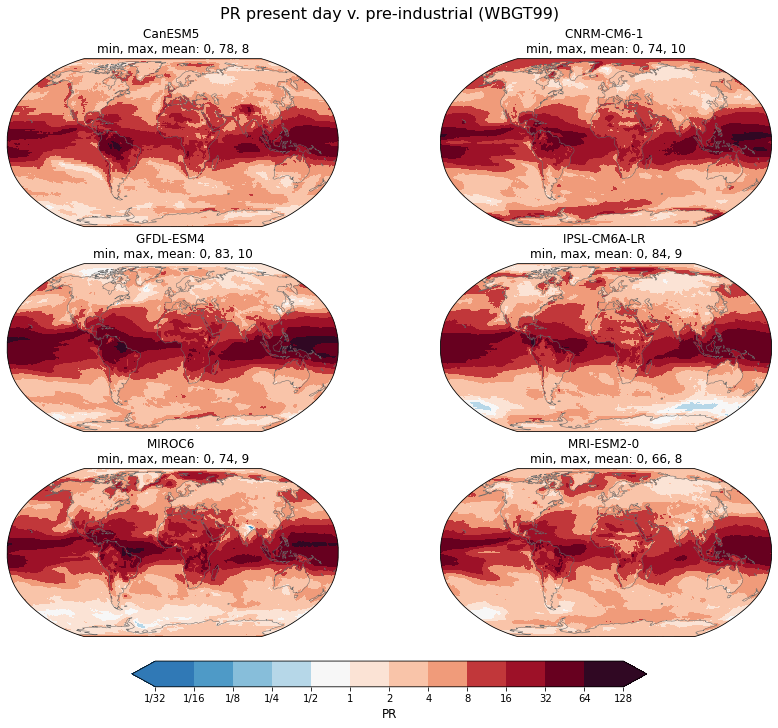

In [13]:
#inputs to functions
bounds, cmap = calc_bounds_cmap_PR_power(8, 'RdBu_r', skew=2)
smooth = 0.3
proj = ccrs.Robinson()

fig, axes = plt.subplots(3,2,figsize=(12,10), subplot_kw={'projection': proj},  layout='constrained')
axes = axes.flatten() 

for GCM, ax in zip(GCMs, axes):
    data_plot = da_WBGT99_PR.sel(model=GCM)
    plot = plot_PR(data_plot, ax, cmap, bounds, title='summary_stats', smooth=0.3, mask=False)

cbar_lab = 'PR' # try to get TeX interpreter 'less likely $\leftarrow$ PR $\rightarrow$ more likely' #'PR' # add more/less likely arrow 
cbar = fig.colorbar(plot, ticks=bounds, extend='both', ax=axes, shrink=0.6, location='bottom', fraction= 0.045, pad= 0.04) #location='bottom' 
labels = ['1/{}'.format(int(1/t)) if t<1 else str(t) for t in bounds]
cbar.ax.set_xticklabels(labels)
cbar.set_label(label=cbar_lab, size=12) 

fig.suptitle('PR present day v. pre-industrial (WBGT99)', size=16);

In [14]:
da_WBGT99_deltaI = open_all_deltaI(GCMs, metric='WBGT99', outdirname=outdirname)
#da_WBGT99_deltaI

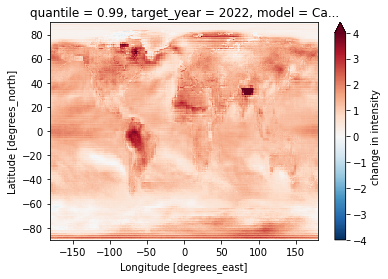

In [15]:
da_WBGT99_deltaI.isel(model=0).plot(vmax=4)

/apps/brussel/RL8/skylake/software/xarray/2022.6.0-foss-2022a/lib/python3.10/site-packages/xarray/coding/times.py:682: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/apps/brussel/RL8/skylake/software/xarray/2022.6.0-foss-2022a/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


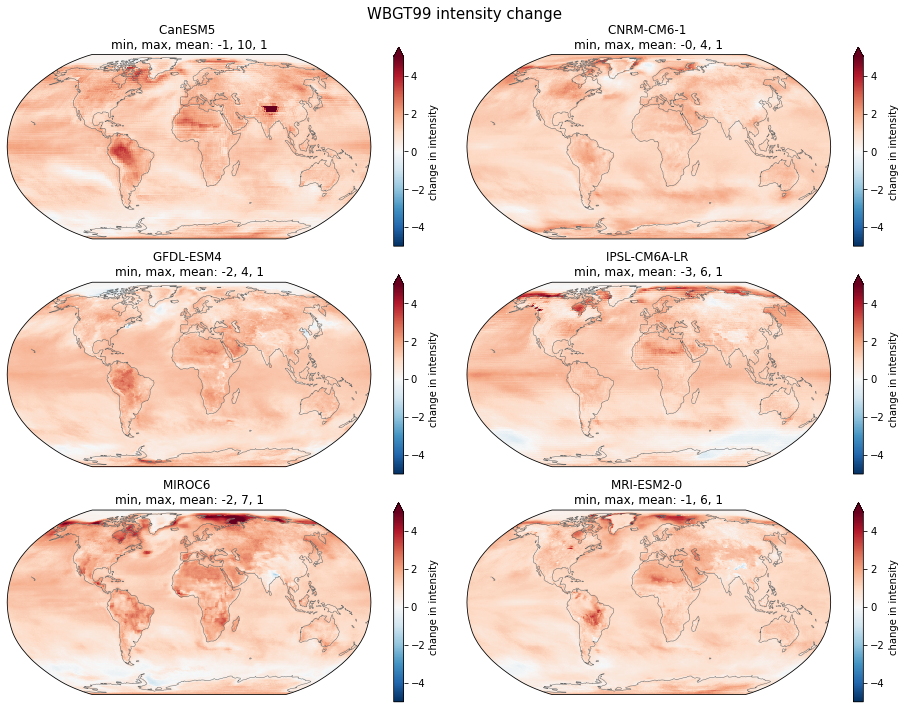

In [16]:
proj = ccrs.Robinson()
landmask = get_mask()
crs = ccrs.PlateCarree()
vmax = 5
levels = np.linspace(-vmax,vmax,num=20)

fig, axes = plt.subplots(3,2,figsize=(13,10), subplot_kw={'projection': proj})
axes = axes.flatten() 

for GCM, ax in zip(GCMs, axes):
    data_plot = da_WBGT99_deltaI.sel(model=GCM) #*landmask
    data_plot.plot(ax=ax, cmap = 'RdBu_r', vmax=vmax, vmin=-vmax, transform=crs, extend='max') 
    ax.set_title(f'{GCM} \nmin, max, mean: {data_plot.min():.0f}, {data_plot.max():.0f}, {data_plot.mean():.0f}')
    ax.coastlines(color='dimgray', linewidth=0.5)
    #ax.add_feature(cfeature.BORDERS, facecolor="none", edgecolor='dimgray', linewidth=0.5 )
    
fig.suptitle('WBGT99 intensity change', size=15);
fig.tight_layout()

In [17]:
da_WBGT99_nAHD = open_all_nAHD(GCMs,  metric='WBGT99', outdirname=outdirname)

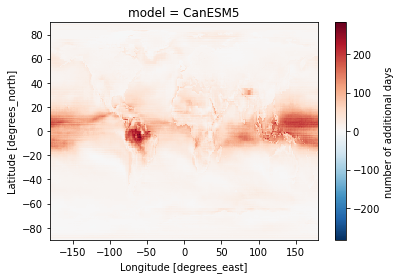

In [18]:
da_WBGT99_nAHD.isel(model=0).plot()

/apps/brussel/RL8/skylake/software/xarray/2022.6.0-foss-2022a/lib/python3.10/site-packages/xarray/coding/times.py:682: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/apps/brussel/RL8/skylake/software/xarray/2022.6.0-foss-2022a/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


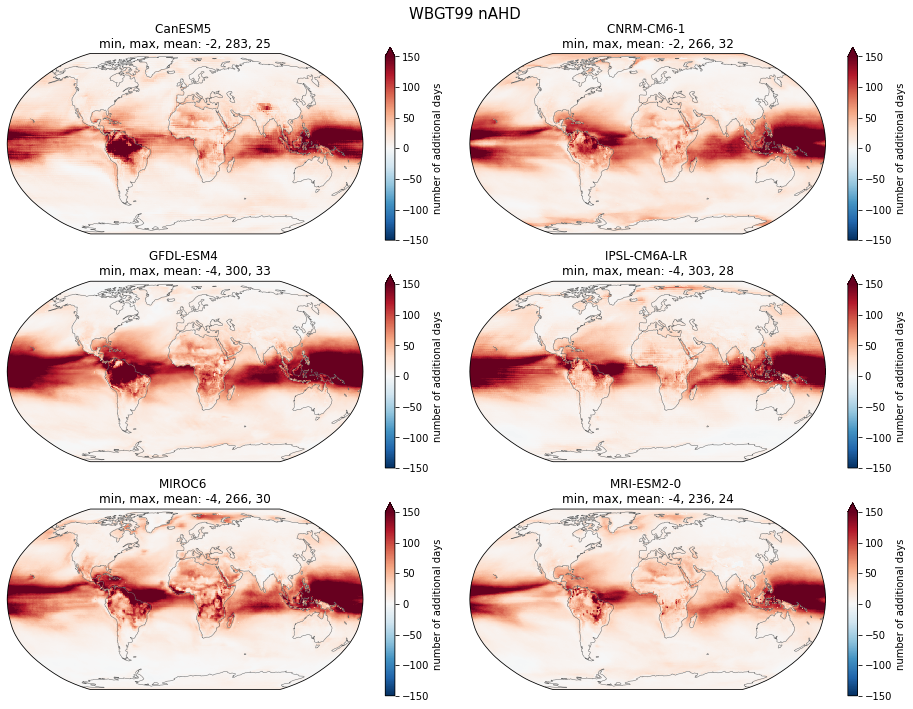

In [19]:
proj = ccrs.Robinson()
landmask = get_mask()
crs = ccrs.PlateCarree()
vmax = 150
levels = np.linspace(-vmax,vmax,num=20)

fig, axes = plt.subplots(3,2,figsize=(13,10), subplot_kw={'projection': proj})
axes = axes.flatten() 

for GCM, ax in zip(GCMs, axes):
    data_plot = da_WBGT99_nAHD.sel(model=GCM) #*landmask
    data_plot.plot(ax=ax, cmap = 'RdBu_r', vmax=vmax, vmin=-vmax, transform=crs, extend='max') 
    ax.set_title(f'{GCM} \nmin, max, mean: {data_plot.min():.0f}, {data_plot.max():.0f}, {data_plot.mean():.0f}')
    ax.coastlines(color='dimgray', linewidth=0.5)
    #ax.add_feature(cfeature.BORDERS, facecolor="none", edgecolor='dimgray', linewidth=0.5 )
    
fig.suptitle('WBGT99 nAHD', size=15);
fig.tight_layout()

/apps/brussel/RL8/skylake/software/xarray/2022.6.0-foss-2022a/lib/python3.10/site-packages/xarray/coding/times.py:682: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/apps/brussel/RL8/skylake/software/xarray/2022.6.0-foss-2022a/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


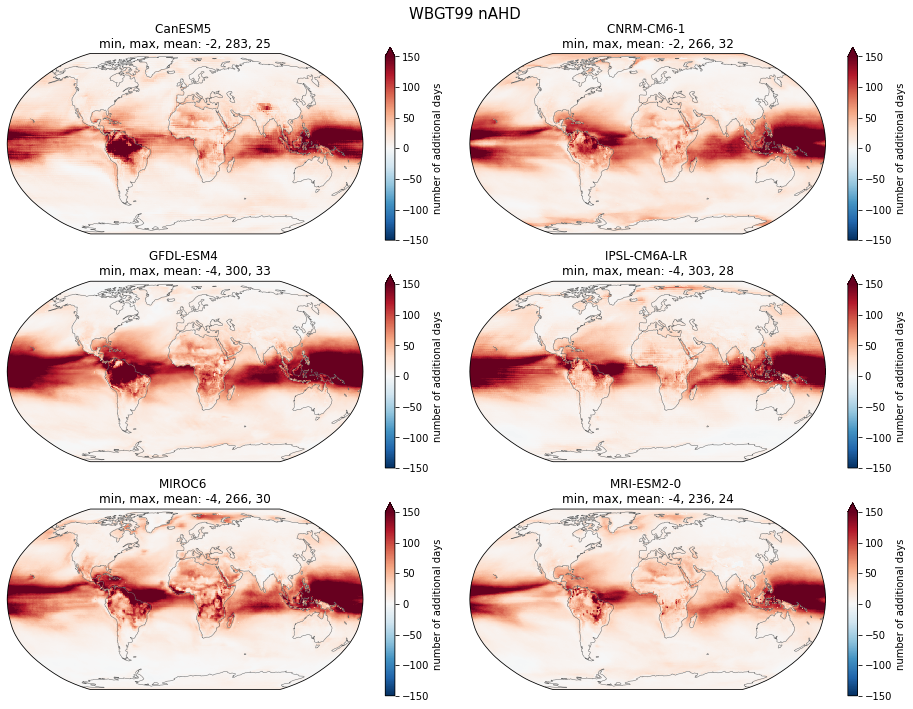

In [52]:
proj = ccrs.Robinson()
landmask = get_mask()
crs = ccrs.PlateCarree()
vmax = 150
levels = np.linspace(-vmax,vmax,num=20)

fig, axes = plt.subplots(3,2,figsize=(13,10), subplot_kw={'projection': proj})
axes = axes.flatten() 

for GCM, ax in zip(GCMs, axes):
    data_plot = da_WBGT99_nAHD.where(da_WBGT99_nAHD !=0).sel(model=GCM) #*landmask
    data_plot.plot(ax=ax, cmap = 'RdBu_r', vmax=vmax, vmin=-vmax, transform=crs, extend='max') 
    ax.set_title(f'{GCM} \nmin, max, mean: {data_plot.min():.0f}, {data_plot.max():.0f}, {data_plot.mean():.0f}')
    ax.coastlines(color='dimgray', linewidth=0.5)
    #ax.add_feature(cfeature.BORDERS, facecolor="none", edgecolor='dimgray', linewidth=0.5 )
    
fig.suptitle('WBGT99 nAHD', size=15);
fig.tight_layout()

## calc with demographics

In [20]:
d_countries = preprocess_all_country_population_data()
gs_population_global = get_gridscale_population_global( 
    d_countries,
    startyear=2022,
    endyear=None,
    save=False # change where this gets saved !!!! now its in package folder
)

interpolating cohort sizes per country
after interpolation and mean-preserving correction there are some neg numbers in 10, Azerbaijan, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 98, Libya, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 136, Papua New Guinea, setting them to zero
Aruba small, population not calculated
Antigua and Barbuda small, population not calculated
Bahrain small, population not calculated
Barbados small, population not calculated
Federated States of Micronesia small, population not calculated
Grenada small, population not calculated
Guam small, population not calculated
Saint Lucia small, population not calculated
Macao small, population not calculated
Maldives small, population not calculated
Malta small, population not calculated
Singapore small, population not calculated
Tonga small, population not calculated
calculating gridscale population per cou

In [21]:
da_n_people_ndays, da_prop_people_ndays = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, GCMs, da_WBGT99_nAHD,  x_hot_days = [1,5,10,20,50])

da_n_people_deltaI, da_prop_people_deltaI = calc_number_proportion_people_atleastdeltaI_10yr(gs_population_global, GCMs, da_WBGT99_deltaI,  thresholds = [0,0.5,1,1.5,3])

da_n_people_PR, da_prop_people_PR = calc_number_proportion_people_atleastPR_10yr(gs_population_global, GCMs, da_WBGT99_PR)



In [22]:
#nAHD
da_n_people_1y, da_prop_people_1y = calc_number_proportion_people_atleastxdays_1yr(gs_population_global, 
                                                                                     GCMs, 
                                                                                     da_WBGT99_nAHD,
                                                                                     x_hot_days = [1, 5, 10, 20, 50], 
                                                                                     ages_values=range(0,100),
                                                                                     grouped = False,
                                                                                     size_win = None
                                                                                    )

In [23]:
da_nAHD_TX99_percapita_peopledays_18y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                           GCMs, 
                                           da_WBGT99_nAHD,
                                           x_hot_days = [1, 5, 10, 20, 50], 
                                           ages_values=range(0,100),
                                           grouped = True,
                                           size_win = 18
                                           )

da_nAHD_percapita_peopledays_10y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                           GCMs, 
                                           da_WBGT99_nAHD,
                                           x_hot_days = [1, 5, 10, 20, 50], 
                                           ages_values=range(0,100),
                                           grouped = True,
                                           size_win = 10
                                           )

da_nAHD_percapita_peopledays_1y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                           GCMs, 
                                           da_WBGT99_nAHD,
                                           x_hot_days = [1, 5, 10, 20, 50], 
                                           ages_values=range(0,100),
                                           grouped = False,
                                           size_win = None
                                           )

In [24]:
da_avgdeltaI_10y = calc_averagedeltaI_peragegroup(gs_population_global, 
                               GCMs, 
                               da_WBGT99_deltaI, 
                               ages_values=range(0,100),
                               grouped = True,
                               size_win = 10
                               )

da_avgdeltaI_18y = calc_averagedeltaI_peragegroup(gs_population_global, 
                               GCMs, 
                               da_WBGT99_deltaI, 
                               ages_values=range(0,100),
                               grouped = True,
                               size_win = 18 #TODO: CHECK 18 or 17!!
                               )

In [25]:
da_avgPR_10y = calc_averagePR_peragegroup(gs_population_global, 
                               GCMs, 
                               da_WBGT99_PR, 
                               ages_values=range(0,100),
                               grouped = True,
                               size_win = 10
                               )

da_avgPR_18y = calc_averagePR_peragegroup(gs_population_global, 
                               GCMs, 
                               da_WBGT99_PR, 
                               ages_values=range(0,100),
                               grouped = True,
                               size_win = 18 #TODO: CHECK 18 or 17!!
                               )

## Plots and key results: climate+exposure (WBGT99)

### 1. nAHD

1. Number of people and proportion of age group living through at least x days 

Text(0.5, 1.0, 'number of people experiencing at least n attributable hot-humid days (>WBGT99) in 2022')

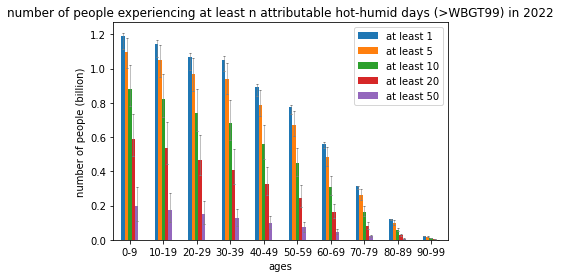

In [49]:
fig, ax = plt.subplots()
plot_barplot_n_prop_people_atleastx_modelmean(da_n_people_ndays, unit=1e9, year=2022, ax=ax, proportion=False)
plt.legend(labels = [f'at least {x}' for x in  [1, 5, 10, 20, 50]])
ax.set_title(f'number of people experiencing at least n attributable hot-humid days (>WBGT99) in 2022')

#plt.savefig(os.path.join(figdir,'n_atleastx_2022_10yr.png'),dpi=300)

Text(0.5, 1.0, 'proportion of age group experiencing at least n attributable hot-humid days (>WBGT99) in 2022')

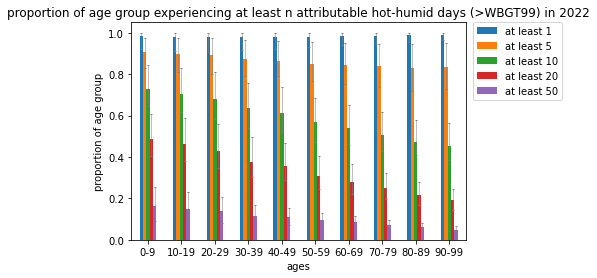

In [50]:
fig, ax = plt.subplots()
plot_barplot_n_prop_people_atleastx_modelmean(da_prop_people_ndays, unit=1, year=2022, ax=ax, proportion=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, labels = [f'at least {x}' for x in  [1, 5, 10, 20, 50]])
ax.set_title(f'proportion of age group experiencing at least n attributable hot-humid days (>WBGT99) in 2022')

#plt.savefig(os.path.join(figdir,'prop_atleastx_2022_10yr.png'),dpi=300)

2. Per capita additional hot days per person : 

note!! these are the additional days, not the total days, baseline would be by definition 3.65 days per yer

In [29]:
df_percapitadays_10y = da_nAHD_percapita_peopledays_10y.sel(features='per_capita_days').to_pandas().T
df_percapitadays_10y

model,CanESM5,CNRM-CM6-1,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0
age_ranges,,,,,,
0,30.364147,26.355838,31.103301,25.628981,37.618475,22.610189
10,29.740862,25.267091,29.888301,24.787040,35.468673,21.740380
20,28.789319,23.931577,28.434945,23.667745,32.936648,20.685627
30,26.475539,21.712139,26.271925,21.568803,28.962686,19.152068
40,25.667783,20.866548,25.483682,20.774666,27.284977,18.512989
50,23.566065,18.916789,23.737802,18.880754,23.989921,17.054643
60,22.262299,17.769637,22.450551,17.697797,22.331799,16.145848
70,20.564348,16.317933,21.031766,16.236402,20.611963,15.090286
80,18.851249,14.846796,19.295529,14.735491,18.956786,13.919406


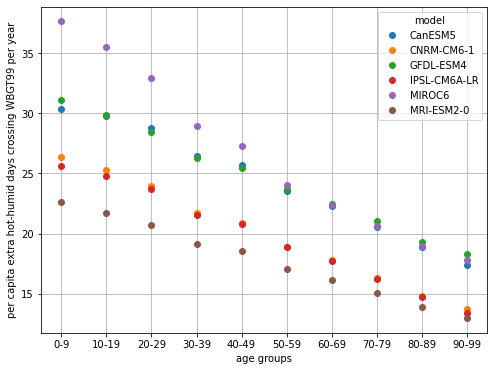

In [30]:
fig, ax = plt.subplots(figsize=(8,6))
df_plot = df_percapitadays_10y
df_plot.plot(marker='o',linestyle='None', ax=ax)
plt.ylabel('per capita extra hot-humid days crossing WBGT99 per year')
plt.xlabel('age groups')
plt.xticks(df_plot.index);
plt.grid()
ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+9}' for x in df_plot.index], rotation='horizontal');

#plt.savefig(os.path.join(figdir,'percapita_hotdays_10y_TX99.png'), dpi=300, transparent=False)


In [31]:
df_percapitadays_18y = da_nAHD_TX99_percapita_peopledays_18y.sel(features='per_capita_days').to_pandas().T
df_percapitadays_18y

model,CanESM5,CNRM-CM6-1,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0
age_ranges,,,,,,
0,30.101262,25.914716,30.612975,25.284244,36.746629,22.261596
18,28.161337,23.354952,27.883777,23.114923,31.927759,20.290246
36,25.467462,20.695965,25.339779,20.607641,27.030797,18.395104
54,22.578349,18.044698,22.788591,17.986866,22.727649,16.374559
72,19.878787,15.728803,20.343982,15.638054,19.958923,14.624402
90,17.382234,13.754319,18.297183,13.416320,17.826517,12.981769


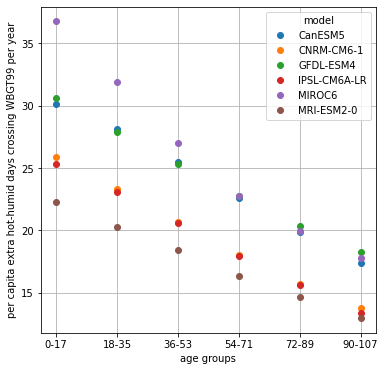

In [32]:
fig, ax = plt.subplots(figsize=(6,6))
df_plot = df_percapitadays_18y
df_plot.plot(marker='o',linestyle='None', ax=ax)
plt.ylabel('per capita extra hot-humid days crossing WBGT99 per year')
plt.xlabel('age groups')
plt.xticks(df_plot.index);
plt.grid()
ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+17}' for x in df_plot.index], rotation='horizontal');

#plt.savefig(os.path.join(figdir,'percapita_hotdays_18y_TX99.png'), dpi=300, transparent=False)

In [33]:
df_percapitadays_18y.median(axis=1)

age_ranges
0     28.007989
18    25.619364
36    23.017872
54    20.311523
72    17.803795
90    15.568277
dtype: float64

In [34]:
df_percapitadays_18y.mean(axis=1)

age_ranges
0     28.486904
18    25.788832
36    22.922791
54    20.083452
72    17.695492
90    15.609724
dtype: float64

3. summary results children v. adults

In [35]:
def calc_weighted_average(df_values, df_weights, start, stop):
    
    ''' stop is excluded'''
    print(f'note: loc {stop} is excluded')
    
    weighted_avg = df_values.iloc[start:stop].multiply(df_weights[start:stop], axis = 0).sum(axis=0).divide(df_weights[start:stop].sum(), axis=0)
    
    return weighted_avg
    
    

In [36]:
def format_large_numbers(x):
    try:
        x = float(x)
        if abs(x) >= 1e9:
            return f'{x/1e9:.1f}B'
        if abs(x) >= 1e6:
            return f'{x/1e6:.1f}M'
        if abs(x) >= 1e3:
            return f'{x/1e3:.1f}K'
        if abs(x) <= 1e2:
            return f'{x:.1f}'
        return str(x)
    except ValueError:
        return x


In [37]:
# number of children versus number of adults living in places where increase 
ch_end = 18
ad_end = 58 

df = da_n_people_1y.sel(features='n_whrincr').to_pandas().T

children_whr_increase = df.iloc[0:ch_end].sum(axis=0)
adults_whr_increase = df.iloc[40:ad_end].sum(axis=0)

In [38]:
df = da_nAHD_percapita_peopledays_1y.sel(features='people_days').to_pandas().T

children_peopledays = df.iloc[0:ch_end].sum(axis=0) 
adults_peopledays = df.iloc[40:ad_end].sum(axis=0)

In [39]:
df_values = da_nAHD_percapita_peopledays_1y.sel(features='per_capita_days').to_pandas().T
df_npeople = da_nAHD_percapita_peopledays_1y.sel(features='n_people').to_pandas().T

children_percapita =  calc_weighted_average(df_values, df_npeople, 0, ch_end)
adults_percapita = calc_weighted_average(df_values, df_npeople,ad_end-18, ad_end)

# repeat this corrected now !! 

note: loc 18 is excluded
note: loc 58 is excluded


In [40]:
df_summary = pd.concat([children_whr_increase,
           adults_whr_increase,
          children_peopledays,
          adults_peopledays,
          children_percapita,
          adults_percapita], axis=1,
         keys= ['children_whr_increase',
           'adults_whr_increase',
          'children_peopledays',
          'adults_peopledays',
          'children_percapita',
          'adults_percapita'])

In [41]:

df_summary.applymap(format_large_numbers)

# this gives the same as above, but different to my old function - check why !! 
# if you do 0-18 included and 40-58 included number of people is the same but people x days and per capita days are different
# see attr-hw-isimip3b-TX99-exposure-dev0 & understand why 

,children_whr_increase,adults_whr_increase,children_peopledays,adults_peopledays,children_percapita,adults_percapita
model,,,,,,
CanESM5,2.2B,1.6B,64.8B,38.7B,30.1,24.8
CNRM-CM6-1,2.1B,1.5B,55.6B,31.1B,25.9,20.1
GFDL-ESM4,2.2B,1.6B,65.9B,38.6B,30.6,24.8
IPSL-CM6A-LR,2.2B,1.6B,54.4B,31.2B,25.3,20.0
MIROC6,2.0B,1.5B,73.7B,38.0B,36.7,26.0
MRI-ESM2-0,2.1B,1.5B,47.6B,27.8B,22.3,17.9


In [42]:
pd.DataFrame(df_summary.median(axis=0), columns=['median']).applymap(format_large_numbers)

,median
children_whr_increase,2.1B
adults_whr_increase,1.6B
children_peopledays,60.2B
adults_peopledays,34.6B
children_percapita,28.0
adults_percapita,22.5


### 2. delta-I 

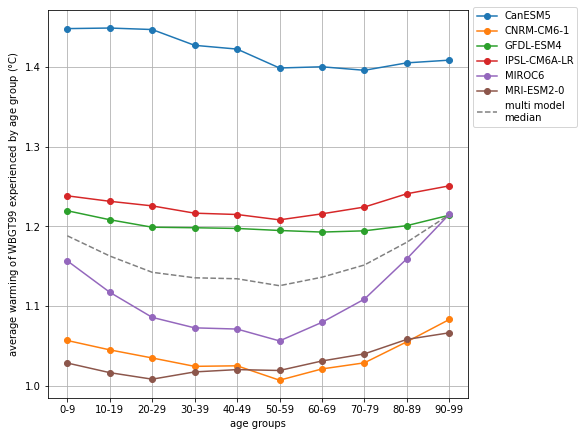

In [43]:
fig, ax = plt.subplots(figsize=(8,6), layout='constrained')

data_plot = da_avgdeltaI_10y.sel(features='avg_deltaI').to_pandas().T
data_plot.plot(ax=ax, marker='o')

da_avgdeltaI_10y.sel(features='avg_deltaI').to_pandas().median(axis=0).plot(ax=ax,c='gray',ls ='--',label='multi model \nmedian')

plt.ylabel('average warming of WBGT99 experienced by age group ($\degree$C)')
plt.xlabel('age groups')
plt.xticks(data_plot.index);
plt.grid()
ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+9}' for x in data_plot.index], rotation='horizontal');
plt.legend(loc=(1.01,.7))


In [44]:
da_avgdeltaI_18y.sel(features='avg_deltaI').to_pandas().round(3)

# average warming of WBGT99 experienced by age group
# note that there's a lot less old people! 

age_ranges,0,18,36,54,72,90
model,,,,,,
CanESM5,1.448,1.441,1.419,1.399,1.400,1.409
CNRM-CM6-1,1.052,1.032,1.021,1.016,1.039,1.083
GFDL-ESM4,1.215,1.199,1.197,1.194,1.197,1.214
IPSL-CM6A-LR,1.236,1.223,1.214,1.213,1.231,1.251
MIROC6,1.141,1.083,1.068,1.072,1.130,1.215
MRI-ESM2-0,1.024,1.011,1.020,1.028,1.047,1.067


In [45]:
da_avgdeltaI_18y.sel(features='avg_deltaI').to_pandas().median(axis=0).round(3)

age_ranges
0     1.178
18    1.141
36    1.133
54    1.133
72    1.163
90    1.215
dtype: float64

### 3. PR

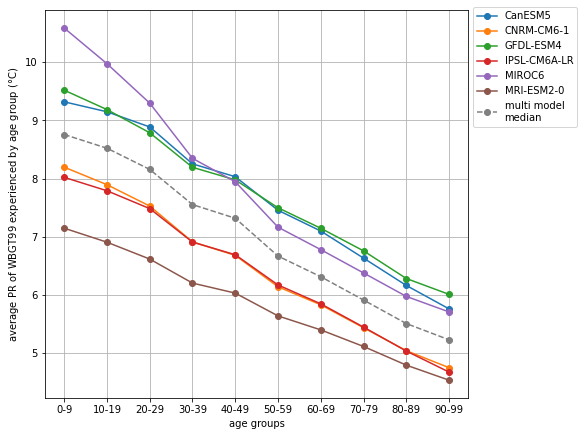

In [46]:
fig, ax = plt.subplots(figsize=(8,6), layout='constrained')

data_plot = da_avgPR_10y.sel(features='avg_PR').to_pandas().T
data_plot.plot(ax=ax, marker='o')

da_avgPR_10y.sel(features='avg_PR').to_pandas().median(axis=0).plot(ax=ax,c='gray',ls ='--', marker='o',label='multi model \nmedian')


plt.ylabel('average PR of WBGT99 experienced by age group ($\degree$C)')
plt.xlabel('age groups')
plt.xticks(data_plot.index);
plt.grid()
ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+9}' for x in data_plot.index], rotation='horizontal');
plt.legend(loc=(1.01,.7));


In [47]:
da_avgPR_18y.sel(features='avg_PR').to_pandas().round(3)


age_ranges,0,18,36,54,72,90
model,,,,,,
CanESM5,9.247,8.715,7.977,7.185,6.446,5.761
CNRM-CM6-1,8.074,7.368,6.633,5.905,5.280,4.752
GFDL-ESM4,9.384,8.636,7.938,7.239,6.570,6.011
IPSL-CM6A-LR,7.927,7.333,6.646,5.928,5.284,4.676
MIROC6,10.340,9.059,7.886,6.870,6.220,5.709
MRI-ESM2-0,7.052,6.512,6.001,5.461,4.988,4.537


In [48]:
da_avgPR_18y.sel(features='avg_PR').to_pandas().median(axis=0).round(2)


age_ranges
0     8.66
18    8.00
36    7.27
54    6.40
72    5.75
90    5.23
dtype: float64